# Apache Spark in R using sparklyr

In September 2016, RStudio announced sparklyr, a new R interface to Apache Spark. sparklyr’s interface to Spark follows the popular dplyr syntax. sparklyr also provides interfaces to Spark’s distributed machine learning algorithms and much more. Highlights include:

1. Interactively manipulate Spark data using both dplyr and SQL (via DBI).
2. Filter and aggregate Spark datasets then bring them into R for analysis and visualization.
3. Orchestrate distributed machine learning from R using either Spark MLlib or H2O SparkingWater.
4. Create extensions that call the full Spark API and provide interfaces to Spark packages.
5. Integrated support for establishing Spark connections and browsing Spark DataFrames within the RStudio IDE.

This notebook covers some fundamental operations, working with spark using the sparklyr package in R. Also, how to work on a machine learning problem using sparklyr is also demonstrated.

Install sparklyr from CRAN as follows:

In [1]:
#install.packages("sparklyr") 

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Also install a local version of Spark for development purposes

In [2]:
library(sparklyr) 
#spark_install(version = "1.6.2")

## Connecting to Spark
We can connect to both local instances of Spark as well as remote Spark clusters. Here we’ll connect to a local instance of Spark:

In [3]:
sc <- spark_connect(master = "local")

* Using Spark: 2.1.0


The returned Spark connection (sc) provides a remote dplyr data source to the Spark cluster.

## Reading Data

We can copy R data frames into Spark using the dplyr copy_to function. (More typically, we will read data within the Spark cluster using the spark_read family of functions.) For the examples below, we’ll copy some datasets from R into Spark.

We need to install the nycflights13 and Lahman packages in order to execute below codes.

In [5]:
install.packages("nycflights13")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [6]:
install.packages("Lahman")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


Now load the dplyr library and copy the three datasets "iris", "flights",and "batting"

In [7]:
library(dplyr) 
iris_tbl <- copy_to(sc, iris) 
flights_tbl <- copy_to(sc, nycflights13::flights, "flights") 
batting_tbl <- copy_to(sc, Lahman::Batting, "batting")


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



## Using dplyr

We can now use all of the available dplyr verbs against the tables within the cluster. Here’s a simple filtering example:

In [8]:
# filter by departure delay 
flights_tbl %>% filter(dep_delay == 2)

# Source:   lazy query [?? x 19]
# Database: spark_connection
    year month   day dep_time sched_dep_time dep_delay arr_time sched_arr_time
   <int> <int> <int>    <int>          <int>     <dbl>    <int>          <int>
 1  2013     1     1      517            515         2      830            819
 2  2013     1     1      542            540         2      923            850
 3  2013     1     1      702            700         2     1058           1014
 4  2013     1     1      715            713         2      911            850
 5  2013     1     1      752            750         2     1025           1029
 6  2013     1     1      917            915         2     1206           1211
 7  2013     1     1      932            930         2     1219           1225
 8  2013     1     1     1028           1026         2     1350           1339
 9  2013     1     1     1042           1040         2     1325           1326
10  2013     1     1     1231           1229         2     1523      

In addition to filter, group_by, summarise, collect can also be performed in a pipelined operation as follows.

In [9]:
delay <- flights_tbl %>% 
  group_by(tailnum) %>%
  summarise(count = n(), dist = mean(distance), delay = mean(arr_delay)) %>%
  filter(count > 20, dist < 2000, !is.na(delay)) %>%
  collect()

We can use ggplot2 to generate some plots

`geom_smooth()` using method = 'gam'


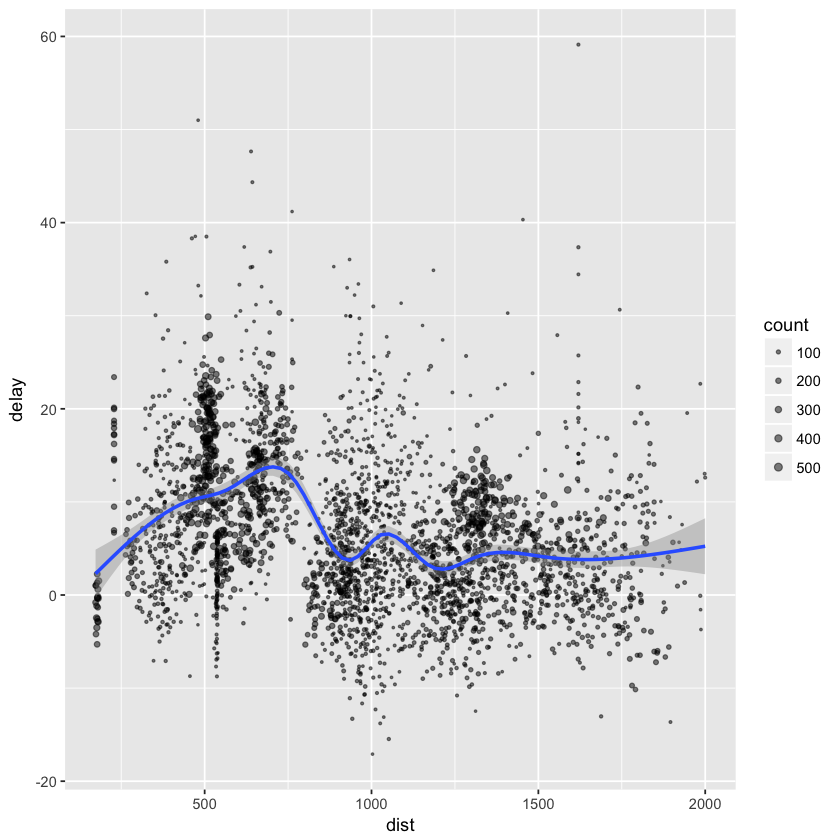

In [10]:
# plot delays
library(ggplot2)
ggplot(delay, aes(dist, delay)) +
  geom_point(aes(size = count), alpha = 1/2) +
  geom_smooth() +
  scale_size_area(max_size = 2)

Note that while the dplyr functions shown above look identical to the ones you use with R data frames, with sparklyr they use Spark as their back end and execute remotely in the cluster.

## Window Functions

Window functions include variations on aggregate functions, like cumsum( ) and cummean( ), functions for ranking and ordering, like rank( ), and functions for taking offsets, like lead( ) and lag( ). Here's an example

In [11]:
batting_tbl %>%   
  select(playerID, yearID, teamID, G, AB:H) %>%   
  arrange(playerID, yearID, teamID) %>%   
  group_by(playerID) %>%   
  filter(min_rank(desc(H)) <= 2 & H > 0)

# Source:     lazy query [?? x 7]
# Database:   spark_connection
# Groups:     playerID
# Ordered by: playerID, yearID, teamID
    playerID yearID teamID     G    AB     R     H
       <chr>  <int>  <chr> <int> <int> <int> <int>
 1 aaronha01   1959    ML1   154   629   116   223
 2 aaronha01   1963    ML1   161   631   121   201
 3  abadfe01   2012    HOU    37     7     0     1
 4 abbated01   1905    BSN   153   610    70   170
 5 abbated01   1904    BSN   154   579    76   148
 6 abbeych01   1894    WAS   129   523    95   164
 7 abbeych01   1895    WAS   132   511   102   141
 8 abbotji01   1999    MIL    20    21     0     2
 9 abnersh01   1992    CHA    97   208    21    58
10 abnersh01   1990    SDN    91   184    17    45
# ... with more rows

## Using SQL

It’s also possible to execute SQL queries directly against tables within a Spark cluster. The spark_connection object implements a DBI interface for Spark, so you can use dbGetQuery to execute SQL and return the result as an R data frame:

In [14]:
#install.packages("DBI")
library(DBI) 
iris_preview <- dbGetQuery(sc, "SELECT * FROM iris LIMIT 10") 
iris_preview

Sepal_Length,Sepal_Width,Petal_Length,Petal_Width,Species
5.1,3.5,1.4,0.2,setosa
4.9,3.0,1.4,0.2,setosa
4.7,3.2,1.3,0.2,setosa
4.6,3.1,1.5,0.2,setosa
5.0,3.6,1.4,0.2,setosa
5.4,3.9,1.7,0.4,setosa
4.6,3.4,1.4,0.3,setosa
5.0,3.4,1.5,0.2,setosa
4.4,2.9,1.4,0.2,setosa
4.9,3.1,1.5,0.1,setosa


## Machine Learning

You can orchestrate machine-learning algorithms in a Spark cluster via either Spark MLlib or via the H2O Sparkling Water extension package. Both provide a set of high-level APIs built on top of DataFrames that help you create and tune machine-learning workflows.

### 1. Using Spark MLlib

In this example we’ll use "ml_linear_regression"  to fit a linear regression model. We’ll use the built-in mtcars dataset, and see if we can predict a car’s fuel consumption (mpg) based on its weight (wt) and the number of cylinders the engine contains (cyl). We’ll assume in each case that the relationship between mpg and each of our features is linear.

In [15]:
# copy mtcars into spark
mtcars_tbl <- copy_to(sc, mtcars)

Lets now do some transformations on the dataset and then split into training and test sets.

In [16]:
# transform our data set, and then partition into 'training', 'test'
partitions <- mtcars_tbl %>%
  filter(hp >= 100) %>%
  mutate(cyl8 = cyl == 8) %>%
  sdf_partition(training = 0.5, test = 0.5, seed = 1099)

Now fit a simple linear regression model

In [18]:
# fit a linear model to the training dataset
fit <- partitions$training %>%
  ml_linear_regression(response = "mpg", features = c("wt", "cyl"))

* No rows dropped by 'na.omit' call


For linear regression models produced by Spark, we can use summary( ) to learn a bit more about the quality of our fit, and the statistical significance of each of our predictors.

In [19]:
summary(fit)

Call: ml_linear_regression(., response = "mpg", features = c("wt", "cyl"))

Deviance Residuals::
   Min     1Q Median     3Q    Max 
-1.752 -1.134 -0.499  1.296  2.282 

Coefficients:
            Estimate Std. Error t value  Pr(>|t|)    
(Intercept) 33.49945    3.62256  9.2475 0.0002485 ***
wt          -2.81846    0.96619 -2.9171 0.0331257 *  
cyl         -0.92319    0.54639 -1.6896 0.1518998    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-Squared: 0.8274
Root Mean Squared Error: 1.422


From the summary, we can infer that cyl may not be a significant predictor for mpg variable.

Spark machine learning supports a wide array of algorithms and feature transformations, and as illustrated above, it’s easy to chain these functions together with dplyr pipelines. To learn more, https://spark.rstudio.com/mllib.html

### 2. Using H2O Sparkling Water

Let’s walk the same mtcars example, but in this case use H2O’s machine-learning algorithms via the H2O Sparkling Water extension. The dplyr code used to prepare the data is the same, but after partitioning into test and training data we call h2o.glm rather than ml_linear_regression:

In [23]:
# convert to h20_frame (uses the same underlying rdd)
library(h2o)
h2o.init()

 Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         1 minutes 23 seconds 
    H2O cluster version:        3.10.5.3 
    H2O cluster version age:    1 month and 21 days  
    H2O cluster name:           H2O_started_from_R_nidhinabraham_got255 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.78 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:      FALSE 
    R Version:                  R version 3.3.2 (2016-10-31) 



Now prepare the training and test sets

In [24]:
training <- as.h2o(partitions$training)
test <- as.h2o(partitions$test)

  |======================================================================| 100%
  |======================================================================| 100%


A linear model fit is given to the data using h2o.glm( )

In [28]:
# fit a linear model to the training dataset
fit <- h2o.glm(x = c("wt", "cyl"),
               y = "mpg",
               training_frame = training)

  |======================================================================| 100%


Model can be summarized as follows

In [30]:
summary(fit)

Model Details:

H2ORegressionModel: glm
Model Key:  GLM_model_R_1503344496337_1 
GLM Model: summary
    family     link                              regularization
1 gaussian identity Elastic Net (alpha = 0.5, lambda = 0.5468 )
  number_of_predictors_total number_of_active_predictors number_of_iterations
1                          2                           2                    0
               training_frame
1 file93414e606758_sid_b1c4_2

H2ORegressionMetrics: glm
** Reported on training data. **

MSE:  2.686872
RMSE:  1.639168
MAE:  1.554845
RMSLE:  0.1001666
Mean Residual Deviance :  2.686872
R^2 :  0.7707814
Null Deviance :93.775
Null D.o.F. :7
Residual Deviance :21.49497
Residual D.o.F. :5
AIC :38.61004





Scoring History: 
            timestamp   duration iteration negative_log_likelihood objective
1 2017-08-21 15:45:06  0.000 sec         0                93.77500  11.72188

Variable Importances: (Extract with `h2o.varimp`) 

Standardized Coefficient Magnitudes: standardized c

## Conclusion

The facilities used internally by sparklyr for its dplyr and machine-learning interfaces are available to extension packages. Since Spark is a general-purpose cluster computing system, there are many potential applications for extensions (e.g. interfaces to custom machine-learning pipelines, interfaces to third-party Spark packages, etc.).